# QT-Assignment-04

by Guillaume IDAME KORALAGE

## Libraries
Let's import libraries we will need first.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
!pip install fbm
from fbm import FBM
from scipy.stats import linregress

## Questions

The goal of this exercise is to simulate an artificial mid-price series with the propagator model and investigate the effect of the decay exponent of the kernel G. 

### Q1: Use the Python fbm library to generate a timeseries of signs with long memory. Specifically the autocorrelation decays as  $${C \sim l^{-\gamma}}$$ 



In [2]:
# Parameters
n = 10000
gamma = 1.5  # Decay exponent for autocorrelation (C(k) ~ k^(-gamma))

# Calculate Hurst exponent based on gamma
H = gamma / 2.0

# Generate fractional Brownian motion
fbm = FBM(n=n, hurst=H)
timeseries = fbm.fbm()

# Calculate autocorrelation function
lags = np.arange(1, n//2)
acf = np.correlate(timeseries, timeseries, mode='full')[n//2:n//2+lags.size] / n

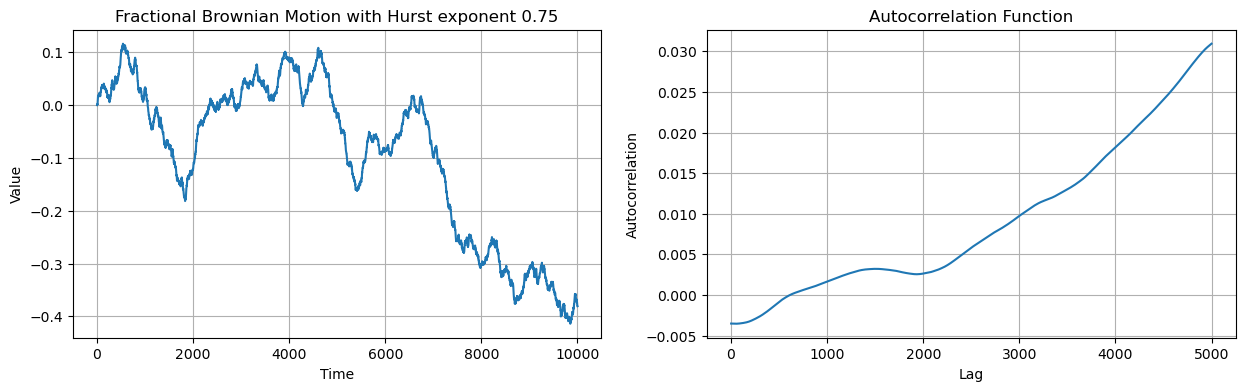

In [3]:
# Plot the generated time series and autocorrelation function
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

axs[0].plot(timeseries)
axs[0].set_title(f'Fractional Brownian Motion with Hurst exponent {H:.2f}')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Value')
axs[0].grid()

axs[1].plot(lags, acf)
axs[1].set_title('Autocorrelation Function')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('Autocorrelation')
axs[1].grid()

### Q2: Estimate the exponent γ.   

In [4]:
# Estimate the decay exponent gamma using linear regression on log-log scale
log_lags = np.log(lags)
log_acf = np.log(acf)
slope, intercept, r_value, p_value, std_err = linregress(log_lags, log_acf)
estimated_gamma = -slope

print(f"True decay exponent (gamma): {gamma:.2f}")
print(f"Estimated decay exponent (gamma): {estimated_gamma:.2f}")

True decay exponent (gamma): 1.50
Estimated decay exponent (gamma): nan


C:\Users\idame\AppData\Local\Temp\ipykernel_15244\3293597230.py:3: RuntimeWarning: invalid value encountered in log
  log_acf = np.log(acf)


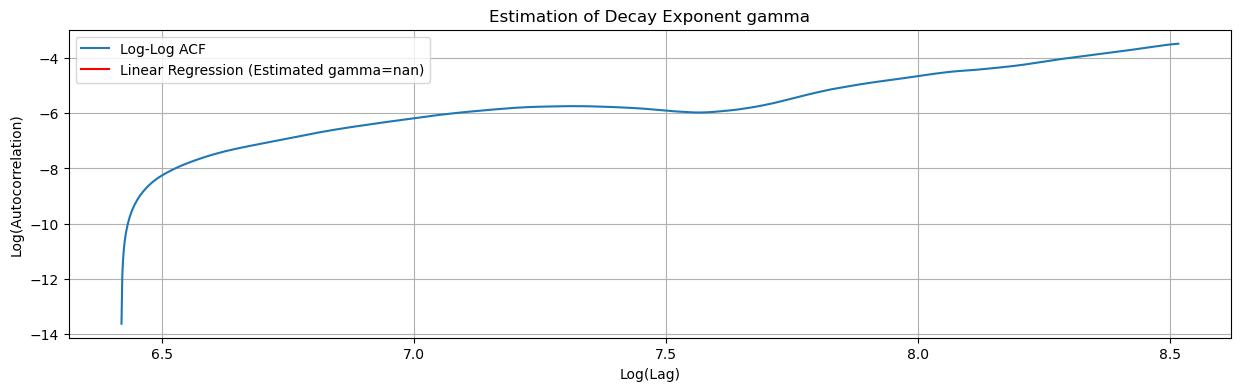

In [5]:
# Plot the log-log regression line and the estimated gamma
fig, ax = plt.subplots(figsize = (15,4))
ax.plot(log_lags, log_acf, label='Log-Log ACF')
ax.plot(log_lags, intercept + slope * log_lags, 'r', label=f'Linear Regression (Estimated gamma={estimated_gamma:.2f})')
ax.set_title('Estimation of Decay Exponent gamma')
ax.set_xlabel('Log(Lag)')
ax.set_ylabel('Log(Autocorrelation)')
ax.legend()
ax.grid()

### Q3: Generate now an artificial series of mid-point prices using a propagator model, where ɛ is the generated time series and ξ is a random noise.
$$
m_t = m_{t_0} + \sum_{t_0≤n<t}  G(t - n) ɛ_n + \sum_{t_0≤n<t} ξ_n
$$

Take for G a power-law kernel as in the cell below.

In [6]:
def G(t, beta=0.3):
    return (t + 1)**(-beta)

First define some new functions.

In [7]:
def G_data(t, beta=0.3):
    """
    Function to generate a series of G
    """
    
    output = []
    
    for i in range(t):
        output.append((i + 1)**(-beta))
        
    return output

signs = np.sign(np.diff(timeseries))

def mid_point_prices(mid_point_start, initial_time_start, t, beta):
    """
    Function to generate a series of mid-prices
    """
    
    np.random.seed(495)
    
    mid_point_prices = []
    sum_1 = 0
    sum_2 = 0
    
    G_series = G_data(t, beta)
    
    for i in range(initial_time_start, t):
        sum_1 += G_series[i] * signs[i]
        sum_2 += np.random.normal(0, 1, 1)
        mid_point_prices.append(mid_point_price_start + sum_1 + sum_2)
        mid_point_prices_array = np.array(mid_point_prices)
        
    return mid_point_prices_array

Now use the functions with our parameters:

In [8]:
mid_point_price_start = 100
initial_time_start = 0

beta = 0.3
t = 10000

mid_point_prices_array = mid_point_prices(mid_point_price_start, initial_time_start, t, beta)

Now plot

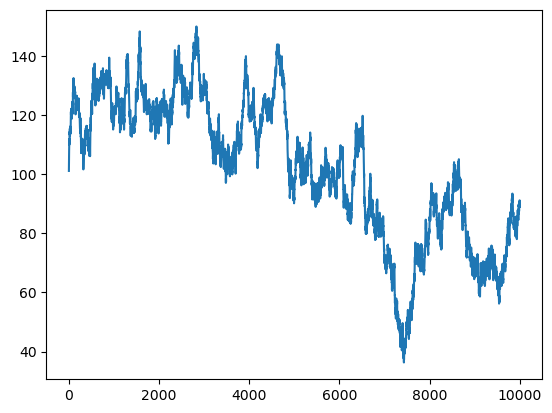

In [9]:
plt.plot(mid_point_prices_array)
plt.show()

### Q4: Estimate the Hurst exponent of the price series (by performing a linear regression of the variagram in log-log scale) for three values of β: β=0.2, β=0.25 and β=-0.3. What is your observation?

First define our function to create variogram

In [10]:
def variogram(timeseries):
    """
    Function to create variogram timeseries
    """
    
    n = len(timeseries)
    v_values = np.zeros(n)

    for lag in range(1, n):
        v_values[lag] = np.mean((timeseries[lag:] - timeseries[:-lag])**2)

    return v_values

Linear regressions:

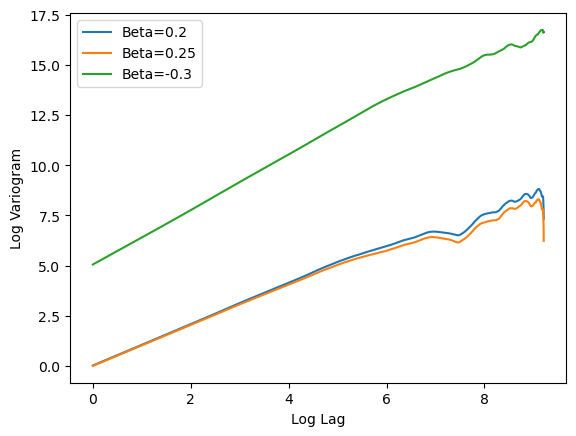

In [11]:
from scipy.stats import linregress

beta_values = [0.2, 0.25, -0.3]
hurst_values = []
for beta in beta_values:

    mid_point_prices_data = mid_point_prices(mid_point_price_start, initial_time_start, t, beta)
    
    # Call variogram and do the lr
    v_values = variogram(np.array(mid_point_prices_data))
    
    log_lags = np.log(np.arange(1, t))
    log_variogram = np.log(v_values[1: ])
    
    slope, intercept, _, _, _ = linregress(log_lags, log_variogram)
    hurst = 0.5 * slope
    
    hurst_values.append(hurst)

    plt.plot(log_lags, log_variogram, label=f'Beta={beta}')
    
plt.xlabel('Log Lag')
plt.ylabel('Log Variogram')
plt.legend()
plt.show()

Hurst exponents per beta:

In [12]:
for i, beta in enumerate(beta_values):
    print(f"The hurst exponent for beta={beta} is {hurst_values[i]:.3f}")

The hurst exponent for beta=0.2 is 0.458
The hurst exponent for beta=0.25 is 0.419
The hurst exponent for beta=-0.3 is 0.534
